In [1]:
import numpy as np
from lwa_antpos import reading, mapping  # Make sure the development branch is installed
from lwa_f import snap2_fengine, snap2_feng_etcd_client
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler
from datetime import datetime
import pyuvdata

Read antpos from default source


In [18]:
snap2names = ['snap01', 'snap02', 'snap03', 'snap04', 'snap05', 'snap06', 'snap07', 'snap08', 'snap09', 'snap10', 'snap11']
Nblocks = 4
Nantpols_per_block = 16
spec = []
snap_nums = []
for snap2name in snap2names:
    print(snap2name)
    snap2num = int(snap2name.lstrip('snap'))
    lwa_f = snap2_fengine.Snap2Fengine(snap2name)
    for pol_block in range(Nblocks):
        spec_new = lwa_f.autocorr.get_new_spectra(pol_block)
        spec.append(spec_new)
        snap_nums.extend([snap2num]*Nantpols_per_block)

snap01


2025-12-09 13:29:16,601 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2025-12-09 13:29:16,871 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1
snap02
2025-12-09 13:29:28,552 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 0
2025-12-09 13:29:28,826 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 1
snap03
2025-12-09 13:29:40,786 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC ADC board on port 0
2025-12-09 13:29:41,058 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC ADC board on port 1
snap04
2025-12-09 13:29:53,167 - lwa_f.blocks.block:snap04 - INFO - adc - Detected FMC ADC board on port 0
2025-12-09 13:29:53,457 - lwa_f.blocks.block:snap04 - INFO - adc - Detected FMC ADC board on port 1


TftpException: Received ERR from server: ERR packet: errorcode = 2
    msg = b'Access violation'

In [19]:
spec = np.concatenate(spec, axis=0)
print(np.shape(spec)) # Shape (Nantpols, Nfreqs)
Nantpols = np.shape(spec)[0]
Nfreqs = np.shape(spec)[1]
frequencies = np.arange(0, Nfreqs) * 23925.78125 * 1e-6

(240, 4096)


In [ ]:
antpol_names = np.empty(Nantpols, dtype='<U10')
use_index = 0
for snap2name in snap2names:
    for pol_block in range(Nblocks):
        for ant_index in range(Nantpols_per_block):
            digitizer_input = ant_index+16*pol_block
            lwa_antname = mapping.snap2digitizer_to_antpol(snap_nums[use_index], digitizer_input)
            #lwa_antname = mapping.snap2_to_antpol(snap_nums[use_index], digitizer_input)
            antpol_names[use_index] = lwa_antname
            use_index += 1
print(antpol_names)

AttributeError: module 'lwa_antpos.mapping' has no attribute 'snap2digitizer_to_antpol'

In [ ]:
antenna_names = np.unique([name[:-1] for name in antpol_names])
Nants = len(antenna_names)
antenna_numbers = np.array([int(name[4:]) for name in antenna_names])

data_array = np.zeros((Nants, 1, Nfreqs, 2), dtype=complex)
for ant_ind, antname in enumerate(antenna_names):
    antpol_ind = np.where(antpol_names == f'{antname}A')
    data_array[ant_ind, 0, :, 0] = spec[antpol_ind, :]
    antpol_ind = np.where(antpol_names == f'{antname}B')
    data_array[ant_ind, 0, :, 1] = spec[antpol_ind, :]

ValueError: invalid literal for int() with base 10: ''

In [ ]:
np.shape(frequencies)

(4096,)

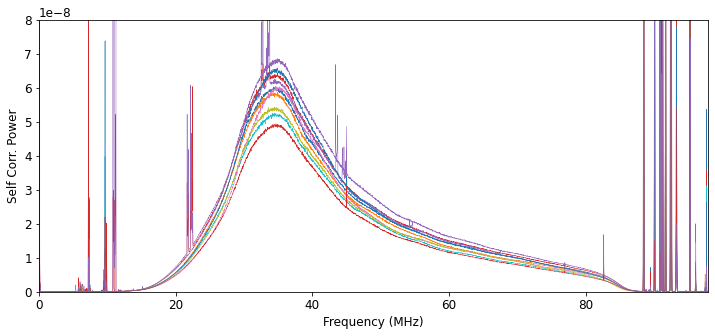

In [24]:
plt.rcParams["font.size"] = 12
plt.rcParams["axes.prop_cycle"] = cycler(
    color=[
        "tab:blue",
        "tab:red",
        "tab:purple",
        "tab:orange",
        "tab:cyan",
        "tab:pink",
        "tab:olive",
    ]
)
fig, ax = plt.subplots(figsize=[12,5])
for ant_ind in [0,2,3,4,5,6,7,8,9,10]:
    ax.plot(
        frequencies,
        spec[ant_ind, :],
        markersize=4,
        linewidth=0.5,
    )
ax.set_ylim([0, 8e-8])
ax.set_xlim([np.min(frequencies), np.max(frequencies)])
# plt.yscale('log')
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Self Corr. Power")
plt.show()

In [ ]:
uv = pyuvdata.UVData()
uv.Nants_data = Nants
uv.Nants_telescope = Nants  # This isn't right
uv.Nbls = uv.Nants_data
uv.Nblts = uv.Nants_data
uv.Nfreqs = len(frequencies)
uv.Npols = 2
uv.Nspws = 1
uv.Ntimes = 1
uv.ant_1_array = antenna_numbers
uv.ant_2_array = antenna_numbers
uv.antenna_names = antenna_names
uv.antenna_numbers = antenna_numbers
uv.baseline_array = 2048*(uv.ant_1_array+1) + (uv.ant_2_array+1) + 2**16
uv.telescope_name = 'OVRO-LWA'
uv.instrument = 'OVRO-LWA'
uv.vis_units = 'uncalib'
uv.data_array = data_array
uv.channel_width = 196./2/Nfreqs*10**6
uv.flag_array = np.zeros((Nants, 1, Nfreqs, 2), dtype=bool)
uv.freq_array = np.reshape(frequencies*10**6, (1, Nfreqs))
uv.history = 'LWA F-engine output autocorrs'
uv.nsample_array = np.ones((Nants, 1, Nfreqs, 2), dtype=float)
uv.polarization_array = np.array([-5, -6])
uv.spw_array = [0]
uv.telescope_location = np.array([-2409247.20369628, -4477889.56236559, 3839327.82827938])
uv.uvw_array = np.zeros((uv.Nblts, 3), dtype=float)
uv.phase_type = 'drift'

# Fill these with dummy variables so pyuvdata is happy
uv.antenna_positions = np.zeros((uv.Nants_telescope, 3))
uv.integration_time = np.zeros(uv.Nants_data, dtype=float)
uv.lst_array = np.zeros(uv.Nblts, dtype=float)
uv.object_name = ''
uv.time_array = np.zeros(uv.Nblts, dtype=float)

uv.check()

NameError: name 'antenna_numbers' is not defined

In [ ]:
uv.write_uvfits(
    f'/home/ubuntu/rbyrne/autocorr_{datetime.now().strftime("%m-%d-%Y_%H:%M")}.uvfits',
    force_phase=True,
    spoof_nonessential=True
)

The data are in drift mode and do not have a defined phase center. Phasing to zenith of the first timestamp.


ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
ERFA function "utcut1" yielded 1 of "dubious year (Note 3)"
ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
ERFA function "epv00" yielded 1 of "warning: date outsidethe range 1900-2100 AD"
ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
